In [60]:
import os
import feedparser
import requests
import re
import folium
import numpy as np
from shapely.geometry import box, shape, Polygon
import geopandas as gpd
from rasterio.mask import mask
import xmltodict
import rasterio.mask

### Query OpenStreetMap data

In [ ]:
network_type="walk"
graph=ox.graph_from_bbox(aoi.total_bounds, network_type=network_type)

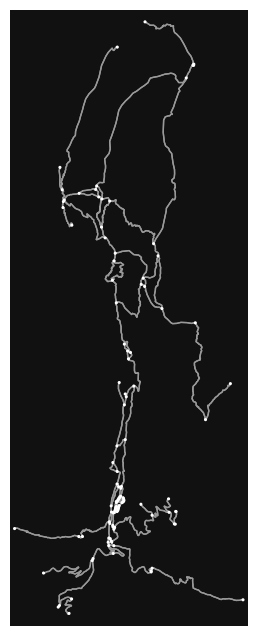

In [ ]:
fig, ax = ox.plot_graph(graph, node_size=5)

In [ ]:
out_file = ox.io.save_graph_geopackage(graph, filepath=f"aoi_{network_type}.gpkg")

### Access AOI data

In [55]:
# path = r"../aoiGeojsonAndShp/aoi.geojson"
path = r"aoi.geojson"
aoi = gpd.read_file(path)
aoi = aoi.set_crs(epsg=31255)
aoi = aoi.to_crs(epsg=3035)

In [56]:
aoi_geom = box(*aoi.total_bounds)
aoi_gdf = gpd.GeoDataFrame(geometry=[aoi_geom], crs="EPSG:3035")
aoi.total_bounds

array([4524323.65321334, 2658894.26911829, 4527066.88937249,
       2666120.18980501])

## Query Website

In [21]:
base = "https://data.bev.gv.at/geonetwork/srv/eng/csw"
params = {
    "service": "CSW",
    "request": "GetRecordById",
    "version": "2.0.2",
    "outputSchema": "http://www.isotc211.org/2005/gmd",
    "ElementSetName": "full",
    "id": "208cff7a-c8aa-42fe-bf4f-2b8156e37528"
}


r = requests.get(base, params=params, timeout=20)
print(r.status_code)
xml = r.text

200


In [22]:
doc = xmltodict.parse(xml)
record = doc['csw:GetRecordByIdResponse']['gmd:MD_Metadata']
ident = record['gmd:identificationInfo']['srv:SV_ServiceIdentification']

title = ident['gmd:citation']['gmd:CI_Citation']['gmd:title']['gco:CharacterString']
abstract = ident['gmd:abstract']['gco:CharacterString']

print("Title:", title)
print("Abstract:", abstract)


Title: AT.BEV ATOM Downloaddienst ALS EL Höhendaten
Abstract: Der ATOM Downloaddienst liefert unentgeltliche INSPIRE Höhendaten (Stichtag).


In [23]:
urls = []
dist = record.get('gmd:distributionInfo', {}).get('gmd:MD_Distribution', {})
if isinstance(dist, list):
    dist = dist[0]

transfer = dist.get('gmd:transferOptions', {})
if isinstance(transfer, list):
    transfer = transfer[0]

digital = transfer.get('gmd:MD_DigitalTransferOptions', {})
online = digital.get('gmd:onLine', [])
if not isinstance(online, list):
    online = [online]

for o in online:
    res = o.get('gmd:CI_OnlineResource', {})
    link = res.get('gmd:linkage', {}).get('gmd:URL')
    name = res.get('gmd:name', {}).get('gco:CharacterString')
    desc = res.get('gmd:description', {}).get('gco:CharacterString')
    if link:
        urls.append({'url': link, 'name': name, 'desc': desc})

for u in urls:
    print(f"{u['name'] or ''}: {u['url']} ({u['desc'] or ''})")

Informationen zum Produkt INSPIRE Downloaddienste: https://www.bev.gv.at/Services/Geoinformationsdienste/INSPIRE-Geodatendienste/INSPIRE-Downloaddienste.html ()
Metadaten AT.BEV ATOM Downloaddienst ALS EL Höhendaten: http://data.bev.gv.at/geonetwork/srv/eng/csw?service=CSW&request=GetRecordById&version=2.0.2&outputSchema=http%3A%2F%2Fwww.isotc211.org%2F2005%2Fgmd&ElementSetName=full&id=208cff7a-c8aa-42fe-bf4f-2b8156e37528 (GetRecordByIdResponse)
XML AT.BEV ATOM Downloaddienst ALS EL Höhendaten: https://data.bev.gv.at/geonetwork/srv/atom/describe/service?uuid=208cff7a-c8aa-42fe-bf4f-2b8156e37528 (Feed)


In [34]:
# Query AOI
feed_url = "https://data.bev.gv.at/geonetwork/srv/atom/describe/service?uuid=208cff7a-c8aa-42fe-bf4f-2b8156e37528"
feed = feedparser.parse(feed_url)

In [38]:
urls = {}
for entry in feed.entries:
    if "DTM CRS3035RES50000mN2650000E4500000" in entry.title:
        urls[(entry.title.split('.')[-1])]= entry.links[-1].href

In [39]:
urls

{'2019': 'https://data.bev.gv.at/geonetwork/srv/atom/describe/dataset?spatial_dataset_identifier_code=https://doi.org/10.48677/1b2e1d2d-8f55-4204-8c55-5305f41e663e&language=de',
 '2021': 'https://data.bev.gv.at/geonetwork/srv/atom/describe/dataset?spatial_dataset_identifier_code=https://doi.org/10.48677/ddee933e-6023-49df-99e3-e8c49623eb46&language=de',
 '2022': 'https://data.bev.gv.at/geonetwork/srv/atom/describe/dataset?spatial_dataset_identifier_code=https://doi.org/10.48677/ee871d1d-aad0-4c85-89b7-076ec62265c0&language=de',
 '2023': 'https://data.bev.gv.at/geonetwork/srv/atom/describe/dataset?spatial_dataset_identifier_code=https://doi.org/10.48677/d3c8bfc0-6f95-4dda-921e-02ad0e89afe0&language=de',
 '2024': 'https://data.bev.gv.at/geonetwork/srv/atom/describe/dataset?spatial_dataset_identifier_code=https://doi.org/10.48677/4a2bbfb4-deb6-48d6-9433-03fc6c76cad2&language=de'}

In [32]:
out_dir = "ALS_DTM_AOI"
os.makedirs(out_dir, exist_ok=True)

In [61]:
for year, url in urls.items():
    feed = feedparser.parse(url)

    for entry in feed.entries:
        download_url = entry.links[-1].href
        year = download_url.split('/')[-2]
        filename = os.path.basename(download_url.split('/')[-1])
        temp_path = os.path.join(out_dir, f"temp_{year}_{filename}")
        clipped_path = os.path.join(out_dir, f"{year}_clipped_{filename}")

        # Download
        try:
            print(f"Downloading...")
            r = requests.get(download_url, stream=True)
            r.raise_for_status()

            with open(temp_path, 'wb') as f:
                for chunk in r.iter_content(chunk_size=8192):
                    f.write(chunk)

            raster_path = temp_path

            # Clip to AOI
            print(f" Clipping to AOI...")
            with rasterio.open(raster_path) as src:
                # Reproject AOI to match raster CRS if needed
                aoi_reprojected = aoi.to_crs(src.crs)

                # Clip
                out_image, out_transform = mask(src, aoi_reprojected.geometry, crop=True)
                out_meta = src.meta.copy()
                out_meta.update({
                    "driver": "GTiff",
                    "height": out_image.shape[1],
                    "width": out_image.shape[2],
                    "transform": out_transform
                })

                # Save clipped raster
                with rasterio.open(clipped_path, "w", **out_meta) as dest:
                    dest.write(out_image)

            # Remove original
            # os.remove(raster_path)
            print(f"Saved clipped: {clipped_path}")

        except Exception as e:
            print(f"Error: {e}")

 Clipping to AOI...
Saved clipped: ALS_DTM_AOI/20190915_clipped_CRS3035RES50000mN2650000E4500000.tif
 Clipping to AOI...
Saved clipped: ALS_DTM_AOI/20210401_clipped_ALS_DTM_CRS3035RES50000mN2650000E4500000.tif
 Clipping to AOI...
Saved clipped: ALS_DTM_AOI/20220915_clipped_ALS_DTM_CRS3035RES50000mN2650000E4500000.tif
 Clipping to AOI...
Saved clipped: ALS_DTM_AOI/20230915_clipped_ALS_DTM_CRS3035RES50000mN2650000E4500000.tif
 Clipping to AOI...
Saved clipped: ALS_DTM_AOI/20240915_clipped_ALS_DTM_CRS3035RES50000mN2650000E4500000.tif
